In [509]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [510]:
# Global config variables
BATCH_SIZE = 200
NUM_CLASSES = 2
LEARNING_RATE = 0.1

## Generate sample time series data

In [511]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

def gen_batch(raw_data, sequence_length, batch_size):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into sequence_length for truncated backprop
    epoch_size = batch_partition_length // sequence_length
    for i in range(epoch_size):
        x = data_x[:, i * sequence_length:(i + 1) * sequence_length]
        y = data_y[:, i * sequence_length:(i + 1) * sequence_length]
        yield (x, y)

def gen_epochs(n, sequence_length):
    (X, Y) = gen_data()
    for i in range(n):
        yield gen_batch((X, Y), sequence_length, batch_size = BATCH_SIZE)

## Constructing RNN

The Basic RNN model:

$S_t = tanh ( W . [X_t, S_{t-1}] + b_s)$

$O_t = \sigma (U . S_t + b_o)$

where

$X_t \in R^{n}$ is the input

$S_t \in R^{h}$ is the internal (memory) state

$O_t \in R^{m}$ is the output

$W \in W^{h \times (n + h)}$

$U \in W^{m \times h}$


In [512]:
def setup_network(state_size, sequence_length, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES):
    """ Set up the RNN graph.
    
    Args:
        state_size: int, The length of the input sequence.
        sequence_length: int, The length of the input sequence. This is the same as 'num_steps', which
                         is number of steps the error at time T shall be backpropagated in times. See
                         https://www.tensorflow.org/tutorials/recurrent#truncated-backpropagation
      
    """
    
    # The placeholders for the data_matrix X, response Y and the intial state for the RNN cell.
    x = tf.placeholder(tf.int32, [batch_size, sequence_length])
    y = tf.placeholder(tf.int32, [batch_size, sequence_length])
    initial_rnn_state = tf.zeros([batch_size, state_size])

    # Convert the input into one-hot encoding
    inputs = tf.one_hot(x, num_classes)
    
    # Define the neural cell and network
    cell = tf.contrib.rnn.BasicRNNCell(state_size)
    cell_output_size = cell.output_size
    outputs, final_rnn_state = tf.nn.dynamic_rnn(cell, inputs, initial_state=initial_rnn_state)
        
    """
    The outputs is [batch_size, sequence_length, state_size]. As we want to the share the weight W and bias b accross
    all the time (sequence) steps, we first flatten the outputs into [batch_size x sequence_length, state_size] before
    running through the softmax layer and computing the cross-entropy loss.
    """
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W', [cell_output_size, num_classes])
        b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
        
    flattened_outputs = tf.reshape(outputs, [-1, cell_output_size])
    flattened_logits = tf.matmul(flattened_outputs, W) + b
    logits = tf.reshape(flattened_logits, [batch_size, sequence_length, num_classes])

    # The loss function and training step
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    train_step = tf.train.AdagradOptimizer(LEARNING_RATE).minimize(loss)
    
    return x, y, initial_rnn_state, final_rnn_state, loss, train_step

In [513]:
def train_network(num_epochs, state_size, sequence_length, batch_size=BATCH_SIZE, verbose=True):
    """ Train the RNN graph.
    
    Args:
        num_epochs: int, The number of units in the RNN cell.
        state_size: int, The length of the input sequence.
        sequence_length: int, The length of the input sequence. This is the same as 'num_steps', which
                         is number of steps the error at time T shall be backpropagated in times. See
                         https://www.tensorflow.org/tutorials/recurrent#truncated-backpropagation
                         
        verbose: boolean, Whether we want to print out the rolling average loss for the last 100 steps.

    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        losses = []
        for index, epoch in enumerate(gen_epochs(num_epochs, sequence_length)):
            rolling_loss = 0
            current_rnn_state = np.zeros((batch_size, state_size))
            if verbose:
                print "EPOCH {}".format(index + 1)
            for step, (X, Y) in enumerate(epoch):
                training_loss_, current_rnn_state, _ = sess.run([loss, final_rnn_state, train_step],
                                                                feed_dict={x:X,
                                                                           y:Y,
                                                                           initial_rnn_state:current_rnn_state}
                                                               )
                
                losses.append(training_loss_)
                rolling_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print "Rolling average loss after {} steps: {}".format(step, rolling_loss/100)
                    rolling_loss = 0

    return losses

EPOCH 1
Rolling average loss after 100 steps: 0.597557731867
Rolling average loss after 200 steps: 0.503422418535
Rolling average loss after 300 steps: 0.488183965683
Rolling average loss after 400 steps: 0.485043308735
EPOCH 2
Rolling average loss after 100 steps: 0.487080459297
Rolling average loss after 200 steps: 0.482058372498
Rolling average loss after 300 steps: 0.482598736882
Rolling average loss after 400 steps: 0.480898693204
EPOCH 3
Rolling average loss after 100 steps: 0.48488863498
Rolling average loss after 200 steps: 0.480253887475
Rolling average loss after 300 steps: 0.481050290167
Rolling average loss after 400 steps: 0.479663088918


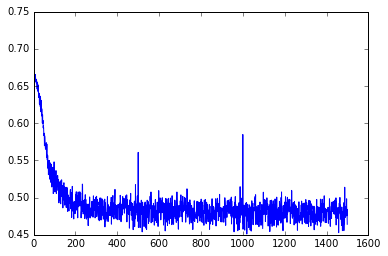

In [514]:
tf.reset_default_graph()

state_size = 6
sequence_length = 10

x, y, initial_rnn_state, final_rnn_state, loss, train_step = setup_network(state_size, sequence_length)
losses = train_network(3, state_size, sequence_length)
plt.plot(losses)